In [1]:
import pandas as pd
import numpy as np

class DataLoader:
    def __init__(self, filepath):
        self.filepath = filepath
    
    def load_data(self):
        data = pd.read_csv(self.filepath)
        return data
    
    def clean_data(self, dataframe):
        dataframe = dataframe.dropna(subset=['Price', 'Beds', 'Baths', 'Living Space', 'Zip Code', 'State'])
        
        dataframe['Zip Code Population'] = dataframe['Zip Code Population'].fillna(0)
        dataframe['Median Household Income'] = dataframe['Median Household Income'].fillna(dataframe['Median Household Income'].median())
        dataframe['Price Category'] = pd.qcut(dataframe['Price'], q=3, labels=[0,1,2])
        return dataframe

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

class FeatureExtract:
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.state_mapping = None
        self.city_mapping = None
        self.original_min_price = None
        self.original_max_price = None
        self.encoders = {}
        
    def extract_features(self, dataframe):
        cat_columns = dataframe.select_dtypes(include=['object']).columns
        num_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
        dataframe['State'], self.state_mapping = self.encode_categorical(dataframe['State'])
        dataframe['City'], self.city_mapping = self.encode_categorical(dataframe['City'])
     
        self.original_min_price = dataframe['Price'].min()
        self.original_max_price = dataframe['Price'].max()
        
        
        for col in cat_columns:
            if col not in self.encoders:
                self.encoders[col] = LabelEncoder()
                dataframe[col] = self.encoders[col].fit_transform(dataframe[col])
            else:
                dataframe[col] = self.encoders[col].transform(dataframe[col])
        
        dataframe[num_columns] = self.scaler.fit_transform(dataframe[num_columns])

        scaled_data = pd.DataFrame(
            self.scaler.fit_transform(dataframe[num_columns]), 
            columns=num_columns, 
            index=dataframe.index
        )
        dataframe[num_columns] = scaled_data
        return dataframe
    
    def encode_categorical(self, column):
        mapping = {category: code for code, category in enumerate(column.unique())}
        reverse_mapping = {v: k for k, v in mapping.items()}
        return column.map(mapping), reverse_mapping

In [3]:
#heap (manually done)
class ManualHeap:
    def __init__(self, is_min_heap=True):
        self.heap = []  
        self.is_min_heap = is_min_heap  

    def compare(self, parent, child):
        if self.is_min_heap:
            return parent > child  
        return parent < child  

    def push(self, key, data):
        self.heap.append((key, data))  
        self._heapify_up(len(self.heap) - 1)  

    def pop(self):
        if not self.heap:
            raise IndexError("Heap is empty")
        
        root_value = self.heap[0]  
        self.heap[0] = self.heap[-1]  
        self.heap.pop()
        self._heapify_down(0)  
        return root_value

    def _heapify_up(self, index):
        parent_index = (index - 1) // 2
        if index <= 0 or not self.compare(self.heap[parent_index][0], self.heap[index][0]):
            return
        self.heap[index], self.heap[parent_index] = self.heap[parent_index], self.heap[index]
        self._heapify_up(parent_index)

    def _heapify_down(self, index):
        child_index = 2 * index + 1
        if child_index >= len(self.heap): 
            return

        if (
            child_index + 1 < len(self.heap) and
            self.compare(self.heap[child_index][0], self.heap[child_index + 1][0])
        ):
            child_index += 1

        if not self.compare(self.heap[index][0], self.heap[child_index][0]):
            return

        self.heap[index], self.heap[child_index] = self.heap[child_index], self.heap[index]
        self._heapify_down(child_index)

In [4]:
from rich.console import Console
from rich.table import Table

class PropertyManagement:
    def __init__ (self, dataframe):
        self.dataframe = dataframe
        self.min_heap = ManualHeap(is_min_heap=True)
        self.max_heap = ManualHeap(is_min_heap=False)
        
    def add_properties(self):
        for _, row in self.dataframe.iterrows():
            property_deets = {
                'Price': row['Price'],
                'Beds': row['Beds'],
                'Baths': row['Baths'], 
                'State': row['State'],
                'City': row['City']
            }
            self.min_heap.push(row['Price'], property_deets)
            self.max_heap.push(row['Price'], property_deets)
    
    def get_cheap_properties(self, n=5):
        cheapest = []
        for _ in range(min(n, len(self.min_heap.heap))):
            cheapest.append(self.min_heap.pop()[1])
        return pd.DataFrame(cheapest)
    
    def get_expensive_properties(self, n=5):
        expensive = []
        for _ in range(min(n, len(self.max_heap.heap))):
            expensive.append(self.max_heap.pop()[1])
        return pd.DataFrame(expensive)
    
    def display_property_prices(self):
        console = Console()
        
        expensive_props = self.get_expensive_properties(n=10)
        cheap_props = self.get_cheap_properties(n=10)
        
        expensive_props['Price'] = expensive_props['Price'].apply(lambda x: f"${x:,.2f}")
        cheap_props['Price'] = cheap_props['Price'].apply(lambda x: f"${x:,.2f}")
        expensive_props['Baths'] = expensive_props['Baths'].apply(lambda x: f"{x:.1f}")
        cheap_props['Baths'] = cheap_props['Baths'].apply(lambda x: f"{x:.1f}")
        
        table_expensive = Table(title="Top 10 Most Expensive Properties", show_lines=True)
        table_cheap = Table(title="Top 10 Cheapest Properties", show_lines=True)

    # Define table columns
        for col in ['Price', 'Beds', 'Baths', 'State', 'City']:
            table_expensive.add_column(col, justify="right" if col in ['Price', 'Beds', 'Baths'] else "center")
            table_cheap.add_column(col, justify="right" if col in ['Price', 'Beds', 'Baths'] else "center")

    # Add rows
        for _, row in expensive_props.iterrows():
            table_expensive.add_row(str(row['Price']), str(row['Beds']), str(row['Baths']), row['State'], row['City'])

        for _, row in cheap_props.iterrows():
            table_cheap.add_row(str(row['Price']), str(row['Beds']), str(row['Baths']), row['State'], row['City'])

    # Display tables
        console.print(table_expensive)
        console.print(table_cheap)
        
        return expensive_props, cheap_props

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class PricePredictor:
    def __init__(self, n_estimators=100, random_state=42):
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        self.features = None
        
    def train_model(self, features, target):
        
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)
        self.features
        self.model.fit(X_train, y_train)
        cross_val = TimeSeriesSplit(n_splits=5)
        cross_scores = cross_val_score(self.model, features, target, cv=cross_val, scoring="accuracy")
        
        predictions = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Test Accuracy: {accuracy:.4f}")
        
        
        return X_test, y_test, predictions
    
    def plot_accuracy(self, features, target, max_trees=100, step=10):
        X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)
        train_accuracy_values = []
        val_accuracy_values = []
        
        for n_estimators in range(10, max_trees+1, step):
            self.model.set_params(n_estimators=n_estimators)
            self.model.fit(X_train, y_train)
            train_acc = self.model.score(X_train, y_train)
            val_acc = self.model.score(X_val, y_val)
            train_accuracy_values.append(train_acc)
            val_accuracy_values.append(val_acc)
        
        plt.plot(range(10, max_trees+1, step), train_accuracy_values, label='Train Accuracy')
        plt.plot(range(10, max_trees+1, step), val_accuracy_values, label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Number of Trees (Simulated Epochs)')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.show()
    
    def predict_price(self, input_features):
        input_array = np.array([input_features])
        return self.model.predict([input_features])[0]

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class Visuals: 
    @staticmethod
    def plot_price_distribution(dataframe, price_column='Price'):
        plt.figure(figsize=(12,6))
        sns.histplot(dataframe[price_column], kde=True, bins=30, color='skyblue')
        plt.title(f"Price Distribution: {price_column}", fontsize=16)
        plt.xlabel("Price", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
     
    @staticmethod
    def plot_feature_correlations(dataframe):
        plt.figure(figsize=(12,8))
        correlation_matrix = dataframe.corr()
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
        plt.title("Feature Correlation Heatmap", fontsize=16)
        plt.xticks(rotation=45)
        plt.show()
    
    @staticmethod
    def plot_predicted_vs_actual(results, actual_col='Actual', predicted_col='Predicted'):
        plt.figure(figsize=(12,6))
        results = results.head(50)
        plt.plot(results.index, results[actual_col], label='Actual', marker='o', linestyle='-', color='blue', alpha=0.8)
        plt.plot(results.index, results[predicted_col], label='Predicted', marker='x', linestyle='--', color='orange', alpha=0.8)
        plt.title("Predicted vs Actual Price Categories", fontsize=16)
        plt.xlabel("Samples", fontsize=14)
        plt.ylabel("Category", fontsize=14)
        plt.legend()
        plt.xticks([])
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    
    @staticmethod
    def plot_price_distribution_by_category(dataframe, price_column='Price', category_column='Price Category', original_min_price=None, original_max_price=None):
        if original_min_price is None or original_max_price is None:
            raise ValueError("original_min_price and original_max_price must be provided to denormalize prices.")
    
        dataframe[price_column] = dataframe[price_column] * (original_max_price - original_min_price) + original_min_price

        plt.figure(figsize=(12, 6))
        sns.boxplot(
            x=category_column,
            y=price_column,
            data=dataframe,
            hue=category_column,
            palette='Set3',
            showfliers=False,
            legend=False
        )

        
        sns.violinplot(
            x=category_column,
            y=price_column,
            data=dataframe,
            hue=category_column,
            palette='Set3',
            inner='quartile',
            density_norm='count',  
            legend=False
        )
        
        plt.title("Price Distribution by Category", fontsize=16)
        plt.xlabel("Price Category", fontsize=14)
        plt.ylabel("Price (Denormalized)", fontsize=14)
        plt.xticks(ticks=[0, 1, 2], labels=['Affordable', 'Mid-Range', 'Premium'], fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend([], [], frameon=False)
        plt.show()

                      Top 10 Most Expensive Properties                      
┏━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃          Price ┃ Beds ┃ Baths ┃        State         ┃       City        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ $38,000,000.00 │    9 │  11.0 │      California      │    Los Angeles    │
├────────────────┼──────┼───────┼──────────────────────┼───────────────────┤
│ $32,000,000.00 │   10 │   7.0 │      California      │   San Francisco   │
├────────────────┼──────┼───────┼──────────────────────┼───────────────────┤
│ $31,900,000.00 │    5 │   9.0 │ District of Columbia │    Washington     │
├────────────────┼──────┼───────┼──────────────────────┼───────────────────┤
│ $31,500,000.00 │    7 │   9.0 │       Florida        │       Miami       │
├────────────────┼──────┼───────┼──────────────────────┼───────────────────┤
│ $28,500,000.00 │    4 │   6.0 │      California      │  West Hollywood   │
├────────────────┼──────┼───────┼──────────────────────┼───────────────────┤
│ $25,000,000.00 │    6 │   7.0 │      California      │   San Francisco   │
├────────────────┼──────┼───────┼──────────────────────┼───────────────────┤
│ $23,888,000.00 │    6 │   7.0 │      California      │    Los Angeles    │
├────────────────┼──────┼───────┼──────────────────────┼───────────────────┤
│ $23,800,000.00 │    5 │   6.0 │      California      │     La Jolla      │
├────────────────┼──────┼───────┼──────────────────────┼───────────────────┤
│ $22,495,000.00 │    7 │   9.0 │      California      │ Pacific Palisades │
├────────────────┼──────┼───────┼──────────────────────┼───────────────────┤
│ $22,000,000.00 │    6 │   9.0 │      California      │   San Francisco   │
└────────────────┴──────┴───────┴──────────────────────┴───────────────────┘

               Top 10 Cheapest Properties                
┏━━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃     Price ┃ Beds ┃ Baths ┃   State    ┃     City      ┃
┡━━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ $1,800.00 │    1 │   1.0 │  New York  │ Staten Island │
├───────────┼──────┼───────┼────────────┼───────────────┤
│ $1,950.00 │    2 │   1.0 │  Florida   │     Miami     │
├───────────┼──────┼───────┼────────────┼───────────────┤
│ $1,995.00 │    3 │   2.0 │ California │    Fresno     │
├───────────┼──────┼───────┼────────────┼───────────────┤
│ $2,000.00 │    3 │   2.0 │ Louisiana  │  New Orleans  │
├───────────┼──────┼───────┼────────────┼───────────────┤
│ $2,200.00 │    2 │   1.0 │  New York  │ Staten Island │
├───────────┼──────┼───────┼────────────┼───────────────┤
│ $2,500.00 │    3 │   1.0 │  New York  │ Staten Island │
├───────────┼──────┼───────┼────────────┼───────────────┤
│ $2,500.00 │    2 │   1.0 │  New York  │   Brooklyn    │
├───────────┼──────┼───────┼────────────┼───────────────┤
│ $2,500.00 │    3 │   1.0 │  New York  │   Brooklyn    │
├───────────┼──────┼───────┼────────────┼───────────────┤
│ $2,750.00 │    3 │   2.0 │  New York  │   Brooklyn    │
├───────────┼──────┼───────┼────────────┼───────────────┤
│ $3,000.00 │    3 │   1.0 │  New York  │   Brooklyn    │
└───────────┴──────┴───────┴────────────┴───────────────┘

Test Accuracy: 0.8279

First 25 Predictions and Actual Values:
   Actual  Predicted
0       2          2
1       0          0
2       2          2
3       2          2
4       0          0
5       2          2
6       1          0
7       0          0
8       2          1
9       1          0
10      0          0
11      1          1
12      2          2
13      2          2
14      2          1
15      1          1
16      0          0
17      2          2
18      2          2
19      2          2
20      1          1
21      0          0
22      0          1
23      0          0
24      0          0


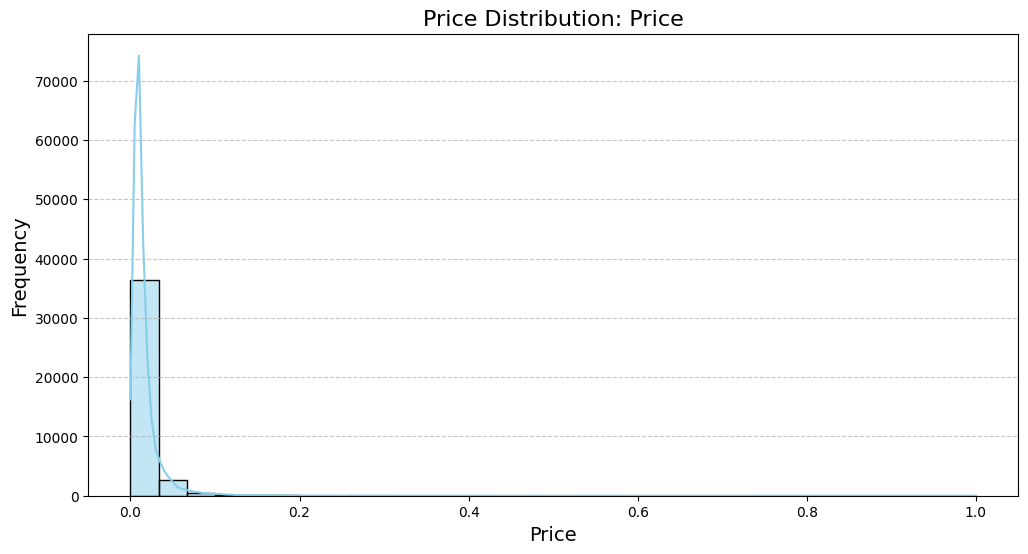

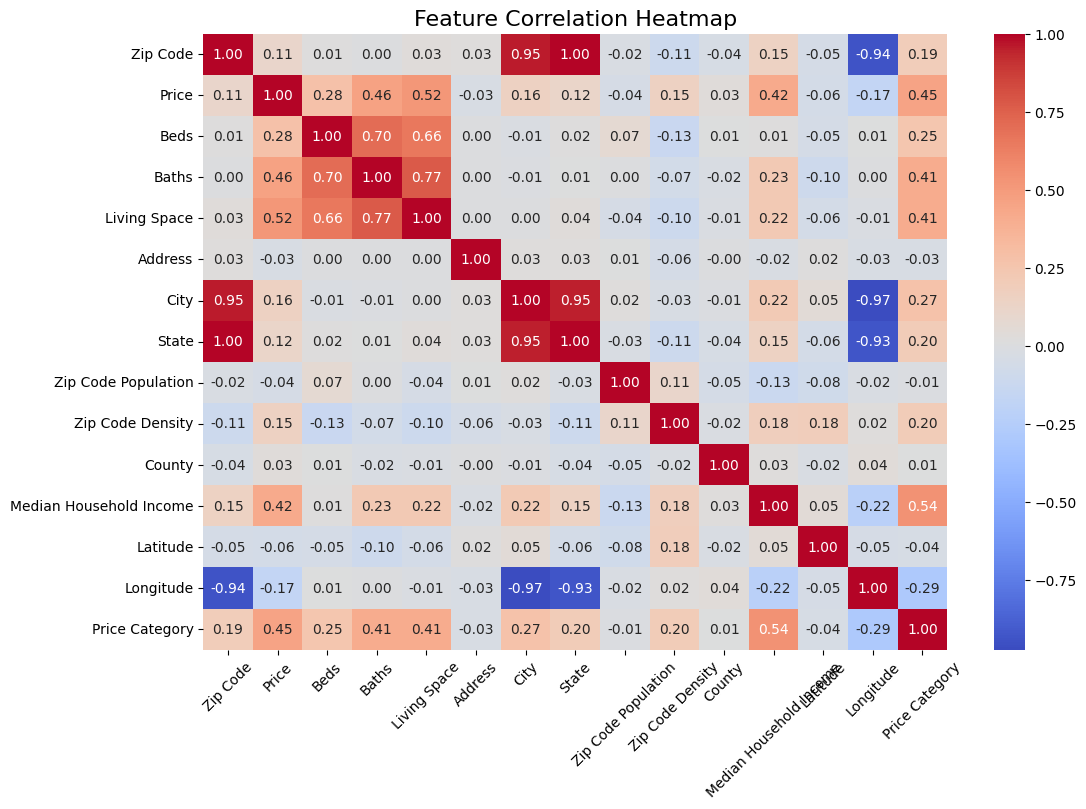

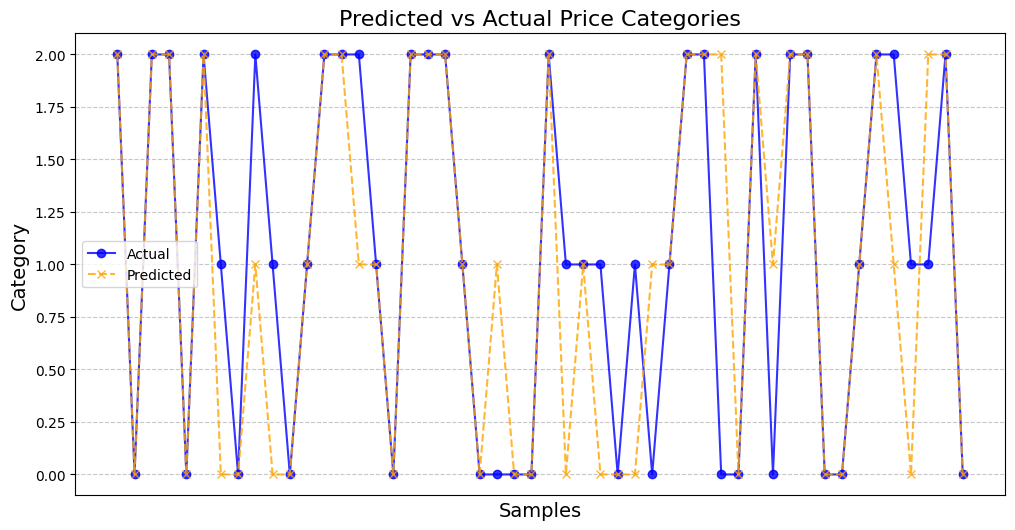

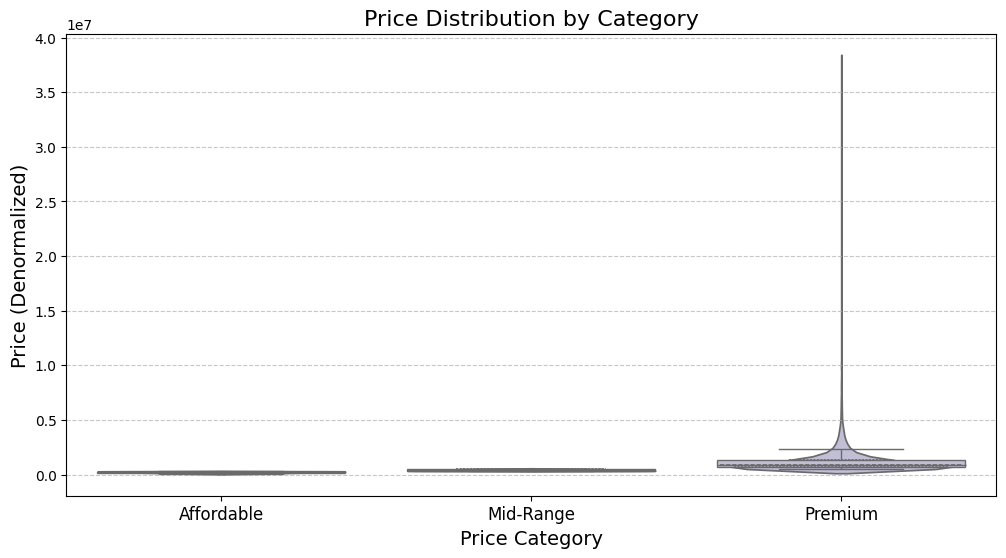

Test Accuracy: 0.8279


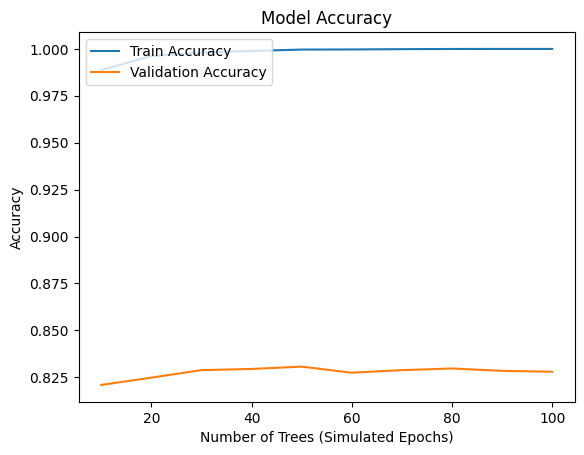

In [7]:
if __name__ == "__main__":
    filepath = r"C:\Users\govin\OneDrive\Desktop\Portfolio projects\House Price Predictor (Zillow)\house_data.csv"
    dataloader = DataLoader(filepath)
    raw_data = dataloader.load_data()
    clean_data = dataloader.clean_data(raw_data)
    
    property_manager = PropertyManagement(clean_data)
    property_manager.add_properties()
    expensive, cheap = property_manager.display_property_prices()

    feature_extract = FeatureExtract()
    processed_data = feature_extract.extract_features(clean_data)
        
    target = processed_data['Price Category']
    features = processed_data.drop(columns=['Price', 'Price Category'])

    predictor = PricePredictor()
    X_test, y_test, predictions = predictor.train_model(features, target)
    
    results = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': predictions
    }).reset_index(drop=True)
    print("\nFirst 25 Predictions and Actual Values:")
    print(results.head(25))
    
    Visuals.plot_price_distribution(clean_data, price_column='Price')
    Visuals.plot_feature_correlations(processed_data)
    Visuals.plot_predicted_vs_actual(results)
    Visuals.plot_price_distribution_by_category(
        clean_data,
        price_column='Price',
        category_column='Price Category',
        original_min_price=feature_extract.original_min_price,
        original_max_price=feature_extract.original_max_price
    )

    price_predict = PricePredictor(n_estimators=100, random_state=42)
    X_train, y_test, predictions = price_predict.train_model(features, target)
    price_predict.plot_accuracy(features, target, max_trees=100, step=10)

Here are 5 test cases that are provided to ensure the reproducibility of my project. 

In [9]:
def test_data_loading_and_cleaning():
    filepath = r"C:\Users\govin\OneDrive\Desktop\Portfolio projects\House Price Predictor (Zillow)\house_data.csv"
    dataloader = DataLoader(filepath)
    
    # Test loading data
    raw_data = dataloader.load_data()
    assert not raw_data.empty, "Raw data should not be empty"
    
    # Test cleaning data
    clean_data = dataloader.clean_data(raw_data)
    assert 'Price Category' in clean_data.columns, "Price Category should be present after cleaning"
    assert not clean_data[['Price', 'Beds', 'Baths', 'Living Space', 'Zip Code']].isnull().any().any(), "There should be no null values in required columns"

    print("Test 1: Data loading and cleaning passed!")
    
test_data_loading_and_cleaning()

Test 1: Data loading and cleaning passed!


In [10]:
def test_feature_extraction():
    filepath = r"C:\Users\govin\OneDrive\Desktop\Portfolio projects\House Price Predictor (Zillow)\house_data.csv"
    dataloader = DataLoader(filepath)
    raw_data = dataloader.load_data()
    clean_data = dataloader.clean_data(raw_data)

    feature_extract = FeatureExtract()
    processed_data = feature_extract.extract_features(clean_data)

    assert 'State' in processed_data.columns, "State column should be encoded"
    assert processed_data.select_dtypes(include=['float64']).shape[1] > 0, "Numerical columns should be scaled"
    assert (processed_data.select_dtypes(include=['float64']) >= 0).all().all() and \
           (processed_data.select_dtypes(include=['float64']) <= 1).all().all(), \
           "All scaled numerical features should be between 0 and 1"

    print("Test 2: Feature extraction passed!")

test_feature_extraction()


Test 2: Feature extraction passed!


In [11]:
def test_manual_heap():
    heap = ManualHeap(is_min_heap=True)
    heap.push(5, "Property A")
    heap.push(3, "Property B")
    heap.push(7, "Property C")

    assert heap.pop()[0] == 3, "Min-heap should return the smallest key first"

    heap_max = ManualHeap(is_min_heap=False)
    heap_max.push(5, "Property A")
    heap_max.push(3, "Property B")
    heap_max.push(7, "Property C")

    assert heap_max.pop()[0] == 7, "Max-heap should return the largest key first"

    print("Test 3: Manual heap passed!")

test_manual_heap()


Test 3: Manual heap passed!


In [12]:
def test_model_training_and_prediction():
    filepath = r"C:\Users\govin\OneDrive\Desktop\Portfolio projects\House Price Predictor (Zillow)\house_data.csv"
    dataloader = DataLoader(filepath)
    raw_data = dataloader.load_data()
    clean_data = dataloader.clean_data(raw_data)

    feature_extract = FeatureExtract()
    processed_data = feature_extract.extract_features(clean_data)

    target = processed_data['Price Category']
    features = processed_data.drop(columns=['Price', 'Price Category'])

    predictor = PricePredictor()
    X_test, y_test, predictions = predictor.train_model(features, target)

    assert len(predictions) == len(y_test), "Number of predictions should match the test set"
    assert 0 <= predictions.min() <= predictions.max() <= 2, "Predictions should fall within the category range [0, 1, 2]"

    print("Test 4: Model training and prediction passed!")

test_model_training_and_prediction()


Test Accuracy: 0.8279
Test 4: Model training and prediction passed!


In [13]:
def test_property_management():
    filepath = r"C:\Users\govin\OneDrive\Desktop\Portfolio projects\House Price Predictor (Zillow)\house_data.csv"
    dataloader = DataLoader(filepath)
    raw_data = dataloader.load_data()
    clean_data = dataloader.clean_data(raw_data)

    property_manager = PropertyManagement(clean_data)
    property_manager.add_properties()

    cheap_properties = property_manager.get_cheap_properties(n=5)
    expensive_properties = property_manager.get_expensive_properties(n=5)

    assert len(cheap_properties) == 5, "Should return exactly 5 cheapest properties"
    assert len(expensive_properties) == 5, "Should return exactly 5 most expensive properties"
    assert cheap_properties['Price'].min() <= expensive_properties['Price'].min(), "Cheapest properties should have lower prices than expensive ones"

    print("Test 5: Property management passed!")

test_property_management()


Test 5: Property management passed!
